# Sentiment Analysis - TripAdvisor

## Introduction: Sentiment Analysis

![image](https://www.kdnuggets.com/images/sentiment-fig-1-689.jpg)

Sentiment analysis is the process of detecting positive or negative sentiment in text. It’s often used by businesses to detect sentiment in social data, gauge brand reputation, and understand customers.

### Why Is Sentiment Analysis Important?
Sentiment analysis is extremely important because it helps businesses quickly understand the overall opinions of their customers. By automatically sorting the sentiment behind reviews, social media conversations, and more, you can make faster and more accurate decisions.

It’s estimated that 90% of the world’s data is unstructured, in other words it’s unorganized. Huge volumes of unstructured business data are created every day: emails, support tickets, chats, social media conversations, surveys, articles, documents, etc). But it’s hard to analyze for sentiment in a timely and efficient manner.

### Some Applications of Sentiment Analysis
The applications of sentiment analysis are endless and can be applied to any industry, from finance and retail to hospitality and technology. Below, we’ve listed some of the most popular ways that sentiment analysis is being used in business:

1. Social Media Monitoring
1. Brand Monitoring
1. Voice of customer (VoC)
1. Customer Service
1. Market Research

### Pipeline of Sentiment Analysis

![pipeline](https://cdn-images-1.medium.com/max/361/0*ga5rNPmVYBsCm-lz.)

## 0. Setup

In [1]:
# General packages
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import seaborn as sns
sns.set_style('darkgrid')

# NLP packages
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from src.tripadvisor_dataset import *
from src.utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 1. Dataset

### Load Data

In [2]:
data_root = os.path.join(os.path.abspath(os.getcwd()), "data", "tripadvisor_hotel_reviews.csv")
# print(data_root)
data = pd.read_csv(data_root)
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
data.shape

(20491, 2)

Check for null values:

In [4]:
# checking for null values
data.isnull().sum()

Review    0
Rating    0
dtype: int64

### Analysing the Data

/home/marci/anaconda3/envs/nlp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Review'>

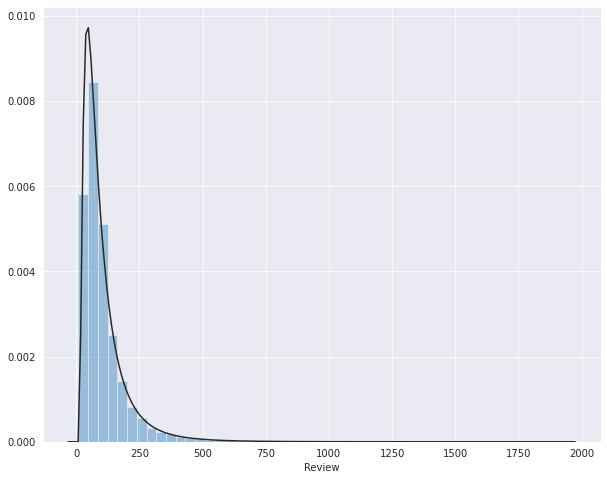

In [5]:
from scipy.stats import lognorm

## Getting the number of words by splitting them by a space
words_per_review = data.Review.apply(lambda x: len(x.split(" ")))
# words_per_review.hist(bins = 100)
# plt.xlabel('Review Length (words)')
# plt.ylabel('Frequency')
# plt.show()

sns.distplot(words_per_review,fit=lognorm, kde=False)

We can observe that the dataset is positively skewed.

In [6]:
print('Average words:', words_per_review.mean())
print('Skewness:', words_per_review.skew())

Average words: 106.3750427016739
Skewness: 4.495935249170961


In [7]:
percent_val = 100 * data['Rating'].value_counts(normalize=True)
percent_val

5    44.185252
4    29.471475
3    10.658338
2     8.750183
1     6.934752
Name: Rating, dtype: float64

<AxesSubplot:xlabel='Rating', ylabel='count'>

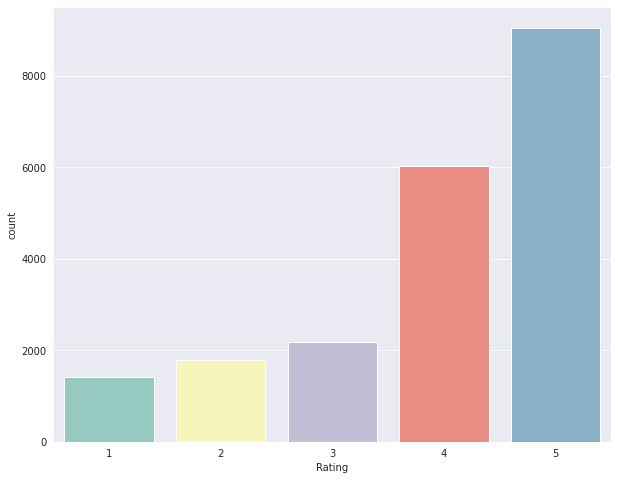

In [8]:
# percent_val.plot.bar()
# plt.show()

sns.countplot(data=data,x='Rating', palette="Set3")

#### Wordcloud of most common words

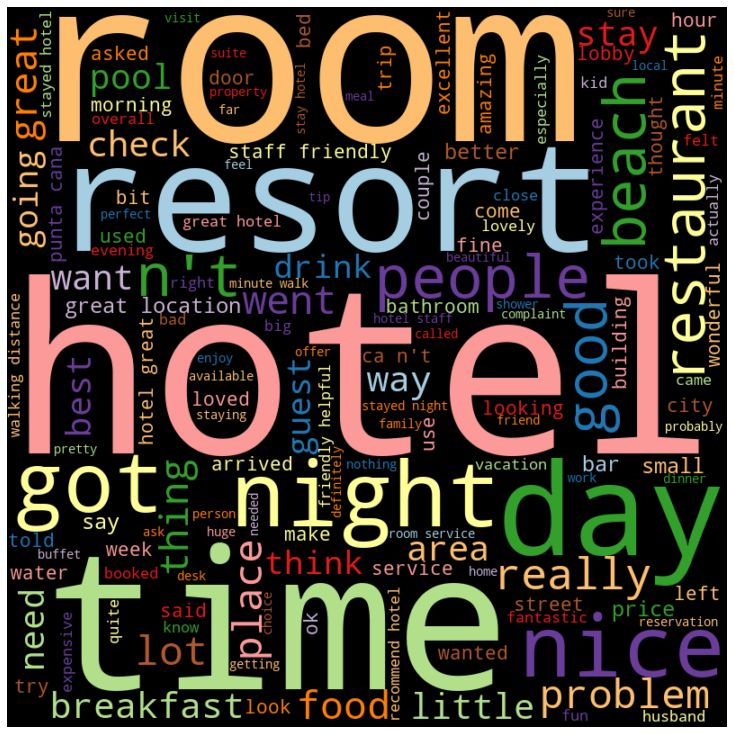

In [9]:
wordcloud_generator(data['Review'])

### Preprocessing Data

#### Convert words to lowercase and remove special characters:
* Remove the Hashtags from the text
* Remove the links from the text
* Remove the twitter handlers
* Remove the Special characters from the text 
* Substitute the multiple spaces with single spaces
* Remove all the single characters in the text


In [10]:
data['Review_preprocessed'] = data['Review'].copy()
# print(type(data['Review_preprocessed']))
clean_data(data, 'Review_preprocessed')

print("- Original Review -")
print(data['Review'][4])
print("\n- New Review -")
print(data['Review_preprocessed'][4])

- Original Review -
great stay great stay, went seahawk game awesome, downfall view building did n't complain, room huge staff helpful, booked hotels website seahawk package, no charge parking got voucher taxi, problem taxi driver did n't want accept voucher barely spoke english, funny thing speak arabic called started making comments girlfriend cell phone buddy, took second realize just said fact speak language face priceless, ass told, said large city, told head doorman issue called cab company promply answer did n't, apologized offered pay taxi, bucks 2 miles stadium, game plan taxi return going humpin, great walk did n't mind, right christmas wonderful lights, homeless stowed away building entrances leave, police presence not greatest area stadium, activities 7 blocks pike street waterfront great coffee shops way, hotel mantained foyer awesome, wine tasting available evening, best dog, taking st. bernard time family, safes hotel located service desk room, bathroom huge jetted tub h

#### Tokenize data and remove stopwords and high/low-frequency words

In [11]:
print('Available languages for NLTK 3.6.3: ')
print(nltk.corpus.stopwords.fileids())

eng_stopwords = nltk.corpus.stopwords.words('english')
print(f'\nExample stopwords: {eng_stopwords[:20]} ...')

Available languages for NLTK 3.6.3: 
['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']

Example stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his'] ...


In [12]:
without_stop_words = []
stopword = []
sentence = data['Review_preprocessed'][4]
words = nltk.word_tokenize(sentence)

for word in words:
    if word in eng_stopwords:
        stopword.append(word)
    else:
        without_stop_words.append(word)

print('-- Original Sentence --\n', sentence)
print('\n-- Stopwords in the sentence --\n', stopword)
print('\n-- Non-stopwords in the sentence --\n', without_stop_words)

-- Original Sentence --
 great stay great stay went seahawk game awesome downfall view building did t complain room huge staff helpful booked hotels website seahawk package no charge parking got voucher taxi problem taxi driver did t want accept voucher barely spoke english funny thing speak arabic called started making comments girlfriend cell phone buddy took second realize just said fact speak language face priceless ass told said large city told head doorman issue called cab company promply answer did t apologized offered pay taxi bucks 2 miles stadium game plan taxi return going humpin great walk did t mind right christmas wonderful lights homeless stowed away building entrances leave police presence not greatest area stadium activities 7 blocks pike street waterfront great coffee shops way hotel mantained foyer awesome wine tasting available evening best dog taking st bernard time family safes hotel located service desk room bathroom huge jetted tub huge funny house keeping walke

In [13]:
data['Review_preprocessed'] = data['Review_preprocessed'].apply(lambda row: stopwords_removal(eng_stopwords, row))
data[['Review','Review_preprocessed']]

,Review,Review_preprocessed
0,nice hotel expensive parking got good deal sta...,"[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,"[ok, nothing, special, charge, diamond, member..."
2,nice rooms not 4* experience hotel monaco seat...,"[nice, rooms, 4, experience, hotel, monaco, se..."
3,"unique, great stay, wonderful time hotel monac...","[unique, great, stay, wonderful, time, hotel, ..."
4,"great stay great stay, went seahawk game aweso...","[great, stay, great, stay, went, seahawk, game..."
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...","[best, kept, secret, 3rd, time, staying, charm..."
20487,great location price view hotel great quick pl...,"[great, location, price, view, hotel, great, q..."
20488,"ok just looks nice modern outside, desk staff ...","[ok, looks, nice, modern, outside, desk, staff..."
20489,hotel theft ruined vacation hotel opened sept ...,"[hotel, theft, ruined, vacation, hotel, opened..."


#### Stemming/lemmatization

In [14]:
porter_stemmer = nltk.stem.porter.PorterStemmer()
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()

# stem_data(data, 'Review_preprocessed', stemmer=porter_stemmer)
lem_data(data, 'Review_preprocessed', lemmatizer=wordnet_lemmatizer)
make_sentences(data, 'Review_preprocessed')

print("- Original Review -")
print(data['Review'][4])
print("\n- New Review -")
print(data['Review_preprocessed'][4])

- Original Review -
great stay great stay, went seahawk game awesome, downfall view building did n't complain, room huge staff helpful, booked hotels website seahawk package, no charge parking got voucher taxi, problem taxi driver did n't want accept voucher barely spoke english, funny thing speak arabic called started making comments girlfriend cell phone buddy, took second realize just said fact speak language face priceless, ass told, said large city, told head doorman issue called cab company promply answer did n't, apologized offered pay taxi, bucks 2 miles stadium, game plan taxi return going humpin, great walk did n't mind, right christmas wonderful lights, homeless stowed away building entrances leave, police presence not greatest area stadium, activities 7 blocks pike street waterfront great coffee shops way, hotel mantained foyer awesome, wine tasting available evening, best dog, taking st. bernard time family, safes hotel located service desk room, bathroom huge jetted tub h

In [15]:
data[['Review','Review_preprocessed']]

,Review,Review_preprocessed
0,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",great stay great stay went seahawk game awesom...
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",best kept secret 3rd time staying charm star c...
20487,great location price view hotel great quick pl...,great location price view hotel great quick pl...
20488,"ok just looks nice modern outside, desk staff ...",ok look nice modern outside desk staff particu...
20489,hotel theft ruined vacation hotel opened sept ...,hotel theft ruined vacation hotel opened sept ...


### Segregating and Encoding Positive, Neutral and Negative Sentiment labels

2    44.185252
1    40.129813
0    15.684935
Name: Sentiment_rating, dtype: float64


<AxesSubplot:xlabel='Sentiment_rating', ylabel='count'>

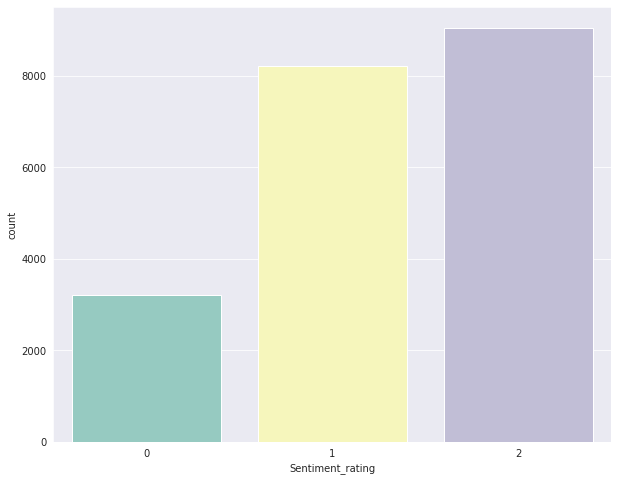

In [16]:
data['Sentiment_rating'] = data['Rating'].apply(sentiment)

# Save preprocessed dataset
preproc_data_root = os.path.join(os.path.abspath(os.getcwd()), "data", "tripadvisor_hotel_reviews_preproc.csv")
data.to_csv(path_or_buf=preproc_data_root, index=False)

# sentiment_rating_distr = 100 * data['Sentiment_rating'].value_counts(normalize=True)
# sentiment_rating_distr.plot.bar()
# plt.show()

percent_val = 100 * data['Sentiment_rating'].value_counts(normalize=True)
print(percent_val)

sns.countplot(data=data,x='Sentiment_rating', palette="Set3")

### Vectorizing the input text

Vectorize the ratings using TF-IDF scores and we will use toarray() to convert resultant sparse matrix to dense matrix.

In [17]:
tfidfconverter = TfidfVectorizer(use_idf=True, max_features=6000, min_df=0, max_df=1.0)
tfidf = tfidfconverter.fit_transform(data['Review_preprocessed']).toarray()
tfidf.shape

### Divide into training and test sets

Stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

Dataset for sentiment and rating classifier:

In [ ]:
SEED = 123

X_train_sen,X_test_sen,y_train_sen,y_test_sen = train_test_split(tfidf,data['Sentiment_rating'],test_size=0.2, random_state=SEED, stratify=data['Sentiment_rating'])

X_train_rat,X_test_rat,y_train_rat,y_test_rat = train_test_split(tfidf,data['Rating'],test_size=0.2, random_state=SEED, stratify=data['Rating'])

### Upsampling using SMOTE

The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the _Synthetic Minority Oversampling Technique_, or **SMOTE** for short.

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

print("Before Upsampling:")
print("\tSentiment: ", Counter(y_train_sen))
print("\tRating: ", Counter(y_train_rat))

# Let's use SMOTE to oversample
oversample = SMOTE()
X_train_sen, y_train_sen = oversample.fit_resample(X_train_sen,y_train_sen)
X_train_rat, y_train_rat = oversample.fit_resample(X_train_rat,y_train_rat)

print("After Upsampling:")
print("\tSentiment: ", Counter(y_train_sen))
print("\tRating: ", Counter(y_train_rat))

Before Upsampling:
	Sentiment:  Counter({2: 7243, 1: 6578, 0: 2571})
	Rating:  Counter({5: 7243, 4: 4831, 3: 1747, 2: 1434, 1: 1137})
After Upsampling:
	Sentiment:  Counter({2: 7243, 1: 7243, 0: 7243})
	Rating:  Counter({5: 7243, 4: 7243, 2: 7243, 3: 7243, 1: 7243})


## 2. Sentiment and Rating Classifiers

### 2.1. Decision Tree

Sentiment analysis:

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)
dt.fit(X_train_sen,y_train_sen)
y_pred_test = dt.predict(X_test_sen)
print("Training Accuracy score: "+str(round(accuracy_score(y_train_sen,dt.predict(X_train_sen)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test_sen,dt.predict(X_test_sen)),4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.5401


In [ ]:
print(classification_report(y_test_sen, y_pred_test, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    positive       0.50      0.53      0.51       643
     neutral       0.49      0.49      0.49      1645
    negative       0.60      0.59      0.59      1811

    accuracy                           0.54      4099
   macro avg       0.53      0.54      0.53      4099
weighted avg       0.54      0.54      0.54      4099



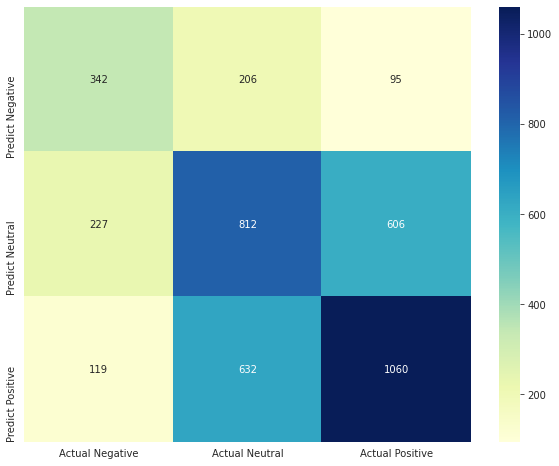

In [22]:
cm = confusion_matrix(y_test_sen, y_pred_test)
# print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

Rating classifier:

In [23]:
des_tree = DecisionTreeClassifier(random_state=SEED).fit(X_train_rat, y_train_rat)

y_pred_dt=des_tree.predict(X_test_rat)

print("Accuracy of Decision Tree Classifier:",accuracy_score(y_test_rat, y_pred_dt))
print(classification_report(y_test_rat, y_pred_dt))

Accuracy of Decision Tree Classifier: 0.44157111490607465
              precision    recall  f1-score   support

           1       0.41      0.45      0.43       284
           2       0.22      0.25      0.23       359
           3       0.20      0.25      0.22       437
           4       0.38      0.38      0.38      1208
           5       0.63      0.56      0.59      1811

    accuracy                           0.44      4099
   macro avg       0.37      0.38      0.37      4099
weighted avg       0.46      0.44      0.45      4099



### 2.2. Naive Bayes Classifier

Sentiment analysis:

In [24]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train_sen, y_train_sen)
y_pred_train = mnb.predict(X_train_sen)
y_pred_test = mnb.predict(X_test_sen)
print("Training Accuracy score: "+str(round(accuracy_score(y_train_sen,mnb.predict(X_train_sen)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test_sen,mnb.predict(X_test_sen)),4)))

Training Accuracy score: 0.785
Testing Accuracy score: 0.7004


In [25]:
print(classification_report(y_test_sen, y_pred_test, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    positive       0.68      0.82      0.74       643
     neutral       0.66      0.62      0.63      1645
    negative       0.75      0.74      0.74      1811

    accuracy                           0.70      4099
   macro avg       0.69      0.72      0.71      4099
weighted avg       0.70      0.70      0.70      4099



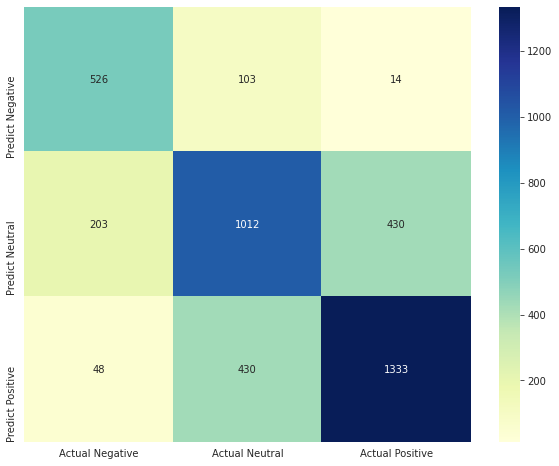

In [26]:
cm = confusion_matrix(y_test_sen, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

Rating classifier:

In [27]:
mnb = MultinomialNB().fit(X_train_rat, y_train_rat) 

y_pred_NB=mnb.predict(X_test_rat)

print("Accuracy of Multinominal Naive Balyes:",accuracy_score(y_test_rat, y_pred_NB))
print(classification_report(y_test_rat, y_pred_NB))

Accuracy of Multinominal Naive Balyes: 0.5686752866552818
              precision    recall  f1-score   support

           1       0.60      0.70      0.65       284
           2       0.30      0.43      0.35       359
           3       0.29      0.36      0.32       437
           4       0.51      0.47      0.49      1208
           5       0.79      0.69      0.74      1811

    accuracy                           0.57      4099
   macro avg       0.50      0.53      0.51      4099
weighted avg       0.60      0.57      0.58      4099



### 2.3. Logistic Regression

Sentiment analysis:

In [28]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=SEED, max_iter=200).fit(X_train_sen, y_train_sen)
y_pred_train = lr.predict(X_train_sen)
y_pred_test = lr.predict(X_test_sen)
print("Training Accuracy score: "+str(round(accuracy_score(y_train_sen,lr.predict(X_train_sen)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test_sen,lr.predict(X_test_sen)),4)))

Training Accuracy score: 0.8604
Testing Accuracy score: 0.7265


In [29]:
print(classification_report(y_test_sen, y_pred_test, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    positive       0.74      0.83      0.78       643
     neutral       0.68      0.65      0.66      1645
    negative       0.76      0.76      0.76      1811

    accuracy                           0.73      4099
   macro avg       0.73      0.75      0.74      4099
weighted avg       0.73      0.73      0.73      4099



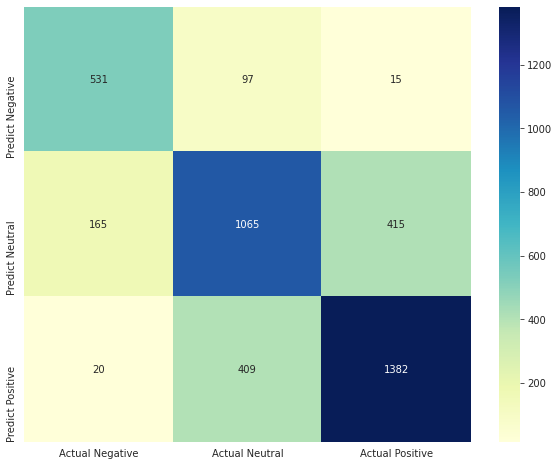

In [30]:
cm = confusion_matrix(y_test_sen, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

Rating classifier:

In [31]:
logreg = LogisticRegression(random_state=SEED, max_iter=300).fit(X_train_rat, y_train_rat)

y_pred_lr=logreg.predict(X_test_rat)

print("Accuracy of Logistic Regression:",accuracy_score(y_test_rat, y_pred_lr))
print(classification_report(y_test_rat, y_pred_lr))

Accuracy of Logistic Regression: 0.5916077091973652
              precision    recall  f1-score   support

           1       0.63      0.69      0.66       284
           2       0.37      0.45      0.40       359
           3       0.34      0.39      0.36       437
           4       0.52      0.48      0.50      1208
           5       0.76      0.73      0.74      1811

    accuracy                           0.59      4099
   macro avg       0.52      0.55      0.53      4099
weighted avg       0.60      0.59      0.60      4099



### 2.4. Random Forest Classifier

Sentiment analysis:

In [32]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train_sen, y_train_sen)
y_pred_train = clf.predict(X_train_sen)
y_pred_test = clf.predict(X_test_sen)
print("Training Accuracy score: "+str(round(accuracy_score(y_train_sen,clf.predict(X_train_sen)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test_sen,clf.predict(X_test_sen)),4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.6914


In [33]:
print(classification_report(y_test_sen, y_pred_test, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    positive       0.70      0.70      0.70       643
     neutral       0.66      0.61      0.63      1645
    negative       0.71      0.76      0.74      1811

    accuracy                           0.69      4099
   macro avg       0.69      0.69      0.69      4099
weighted avg       0.69      0.69      0.69      4099



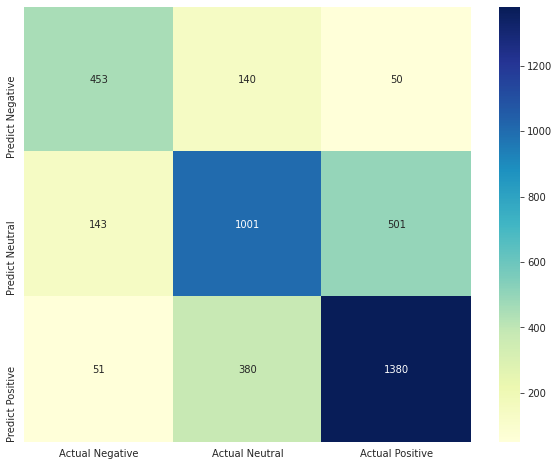

In [34]:
cm = confusion_matrix(y_test_sen, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

Rating classifier:

In [35]:
rf = RandomForestClassifier().fit(X_train_rat, y_train_rat)

y_pred_rf=rf.predict(X_test_rat)

print("Accuracy of Random Forest Classifier:",accuracy_score(y_test_rat, y_pred_rf))
print(classification_report(y_test_rat, y_pred_rf))

Accuracy of Random Forest Classifier: 0.5598926567455477
              precision    recall  f1-score   support

           1       0.58      0.67      0.62       284
           2       0.30      0.19      0.23       359
           3       0.32      0.19      0.24       437
           4       0.49      0.43      0.45      1208
           5       0.65      0.79      0.71      1811

    accuracy                           0.56      4099
   macro avg       0.47      0.45      0.45      4099
weighted avg       0.53      0.56      0.54      4099



### 2.5. XGBoost

Sentiment analysis:

In [36]:
#takes huge amount of time to execute
# import xgboost as xgb

# xgboost_clf = xgb.XGBClassifier().fit(X_train_sen, y_train_sen)

# y_pred_xgb=xgboost_clf.predict(X_test_sen)

# print("Accuracy of XGBoost Classifier:",accuracy_score(y_test_sen, y_pred_xgb))
# print(classification_report(y_pred_xgb,y_test_sen))

### 2.6. k-Nearest Neighbours (KNN)

Sentiment analysis:

In [37]:
from sklearn.neighbors import KNeighborsClassifier 

knn = KNeighborsClassifier(n_neighbors = 5).fit(X_train_sen, y_train_sen)

y_pred_knn=knn.predict(X_test_sen)

print("Accuracy of k-nearest neighbours Classifier:",accuracy_score(y_test_sen, y_pred_knn))
print(classification_report(y_test_sen, y_pred_knn, target_names=['negative', 'neutral', 'positive']))

Accuracy of k-nearest neighbours Classifier: 0.2839717004147353
              precision    recall  f1-score   support

           0       0.21      0.96      0.34       643
           1       0.45      0.28      0.34      1645
           2       0.80      0.05      0.09      1811

    accuracy                           0.28      4099
   macro avg       0.48      0.43      0.26      4099
weighted avg       0.56      0.28      0.23      4099



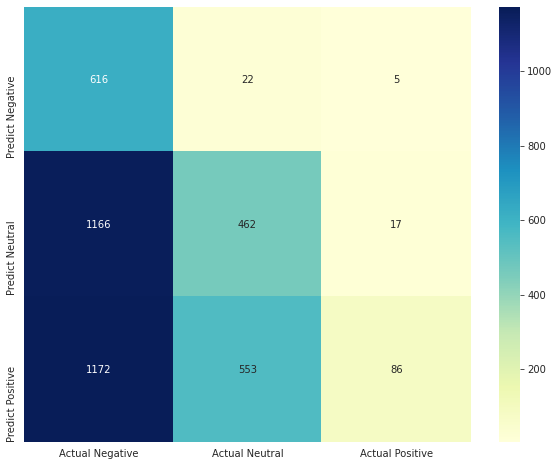

In [38]:
cm = confusion_matrix(y_test_sen, y_pred_knn)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

Rating classifier:

In [39]:
knn = KNeighborsClassifier(n_neighbors = 5).fit(X_train_rat, y_train_rat)

y_pred_knn=knn.predict(X_test_rat)

print("Accuracy of k-nearest neighbours Classifier:",accuracy_score(y_test_rat, y_pred_knn))
print(classification_report(y_test_rat, y_pred_knn))

Accuracy of k-nearest neighbours Classifier: 0.21029519394974383
              precision    recall  f1-score   support

           1       0.24      0.52      0.33       284
           2       0.14      0.35      0.20       359
           3       0.13      0.46      0.20       437
           4       0.36      0.29      0.32      1208
           5       0.87      0.02      0.04      1811

    accuracy                           0.21      4099
   macro avg       0.35      0.33      0.22      4099
weighted avg       0.53      0.21      0.17      4099



### 2.7. Support Vector Machines (SVM)

Sentiment analysis:

In [40]:
# takes a long time
from sklearn.svm import SVC

svc = SVC(C=1, max_iter=100,random_state=SEED).fit(X_train_sen, y_train_sen)
y_pred_svm=svc.predict(X_test_sen)

print("Accuracy of SVM Classifier:", accuracy_score(y_test_sen, y_pred_svm))
print(classification_report(y_test_sen, y_pred_svm, target_names=['negative', 'neutral', 'positive']))

Accuracy of SVM Classifier: 0.7335935594047328
              precision    recall  f1-score   support

           0       0.84      0.73      0.78       643
           1       0.68      0.68      0.68      1645
           2       0.75      0.78      0.77      1811

    accuracy                           0.73      4099
   macro avg       0.75      0.73      0.74      4099
weighted avg       0.74      0.73      0.73      4099



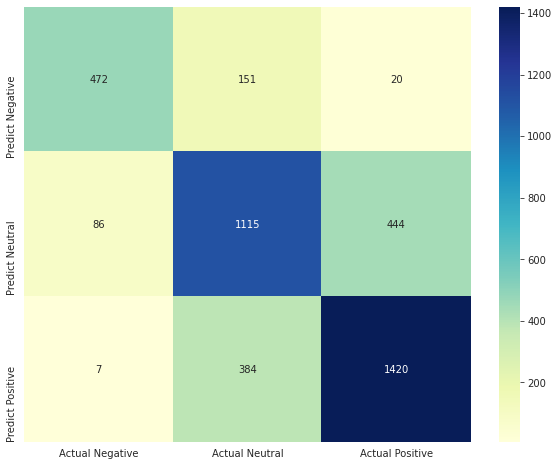

In [41]:
cm = confusion_matrix(y_test_sen, y_pred_svm)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

Rating classifier:

In [42]:
svc = SVC(C=1, max_iter=100, random_state=SEED).fit(X_train_rat, y_train_rat)

y_pred_svm=svc.predict(X_test_rat)

print("Accuracy of SVM Classifier:",accuracy_score(y_test_rat, y_pred_svm))
print(classification_report(y_test_rat, y_pred_svm))

Accuracy of SVM Classifier: 0.624786533300805
              precision    recall  f1-score   support

           1       0.71      0.62      0.67       284
           2       0.46      0.45      0.46       359
           3       0.44      0.23      0.30       437
           4       0.53      0.53      0.53      1208
           5       0.72      0.81      0.77      1811

    accuracy                           0.62      4099
   macro avg       0.57      0.53      0.54      4099
weighted avg       0.61      0.62      0.61      4099

